In [2]:
!wget https://md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com/rp73yg93n8-1.zip -nc -P ./data/
!unzip -n ./data/rp73yg93n8-1.zip -d ./data/
!unzip -n -q ./data/fruits-360_dataset.zip -d ./data/ 

--2021-02-07 09:15:54--  https://md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com/rp73yg93n8-1.zip
Resolving md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com (md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com)... 52.218.104.227
Connecting to md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com (md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com)|52.218.104.227|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 418811602 (399M) [application/octet-stream]
Saving to: ‘./data/rp73yg93n8-1.zip’

rp73yg93n8-1.zip    100%[===================>] 399.41M  34.7MB/s    in 12s     

2021-02-07 09:16:07 (32.9 MB/s) - ‘./data/rp73yg93n8-1.zip’ saved [418811602/418811602]

Archive:  ./data/rp73yg93n8-1.zip
  inflating: ./data/fruits-360_dataset.zip  


In [3]:
import os
import torch
import numpy as np
from PIL import Image

import matplotlib.pyplot as plt
from skimage import io, transform
from natsort import natsorted
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
from torch.utils.data import Dataset
from torch.autograd import Variable
from torchvision.utils import save_image, make_grid
import torch.nn.init as init
from torchsummary import summary

In [4]:
IMAGE_SIZE = 96
EMBED_SIZE = 128
BATCH_SIZE = 16
EPOCHS = 1000

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
kwargs = {'num_workers': 1, 'pin_memory': True} if torch.cuda.is_available() else {}

In [ ]:
COLAB_FLG = True
if COLAB_FLG:
    from google.colab import drive
    drive.mount('/content/drive')
    ATTACH_PATH = "/content/drive/My Drive/PyTorch-GAN/"
else:
    ATTACH_PATH = "."
    

SAVE_MODEL_PATH = f"{ATTACH_PATH}/results/AnoGAN/model/"
SAVE_IMAGE_FROM_Z_PATH = f"{ATTACH_PATH}/results/AnoGAN/image/image_from_z/"
SAVE_IMAGE_RECONSTRUCT = f"{ATTACH_PATH}/results/AnoGAN/image/RECONSTRUCT/"

os.makedirs(SAVE_MODEL_PATH, exist_ok=True)
os.makedirs(SAVE_IMAGE_FROM_Z_PATH, exist_ok=True)
os.makedirs(SAVE_IMAGE_RECONSTRUCT, exist_ok=True)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:




train_root = './data/fruits-360/Training/Physalis/'
test_root = './data/fruits-360/Test/Physalis/'


In [ ]:
class LoadFromFolder(Dataset):
    def __init__(self, main_dir, transform):
        self.main_dir = main_dir
        self.transform = transform
        all_imgs = natsorted(os.listdir(main_dir))
        self.all_imgs_name = natsorted(all_imgs)
        self.imgs_loc = [os.path.join(self.main_dir, i) for i in self.all_imgs_name]

    def __len__(self):
        return len(self.all_imgs_name)
    
    def load_image(self, path):
        image = Image.open(path).convert("RGB")
        tensor_image = self.transform(image)
        return tensor_image
    
    def __getitem__(self, idx):
        
        if type(idx) == slice:
            paths = self.imgs_loc[idx]
            tensor_image = [self.load_image(path) for path in paths]
            tensor_image = torch.cat(tensor_image).reshape(len(tensor_image), *tensor_image[0].shape)
        elif type(idx) == int:
            path = self.imgs_loc[idx]
            tensor_image = self.load_image(path)
        return tensor_image

In [ ]:
transform_dict = {
        'train': transforms.Compose(
            [transforms.Resize((IMAGE_SIZE,IMAGE_SIZE)),
             transforms.RandomHorizontalFlip(),
             transforms.ToTensor(),
             ]),
        'test': transforms.Compose(
            [transforms.Resize((IMAGE_SIZE,IMAGE_SIZE)),
             transforms.ToTensor(),
             ])}

In [ ]:
train_dataset = LoadFromFolder(train_root, transform=transform_dict["train"])

test_dataset = LoadFromFolder(test_root, transform=transform_dict["test"])

train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size = BATCH_SIZE, shuffle=True, **kwargs)

val_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size = BATCH_SIZE, shuffle=True, **kwargs)

In [ ]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.main = nn.Sequential(
            nn.ConvTranspose2d(EMBED_SIZE, 256, kernel_size=6, stride=1, padding=0, bias=False), # 6x6
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False), # 12x12
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False), # 24x24
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1, bias=False), # 48x48
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(32, 3, kernel_size=4, stride=2, padding=1, bias=False), #96x96
            nn.Tanh()
        )

    def forward(self, z):
        out = self.main(z)
        return out

In [ ]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.main = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=4, stride=2, padding=1, bias=False),
            # nn.BatchNorm2d(32),
            nn.LeakyReLU(0.1, inplace=True), #48x48
            nn.Dropout2d(p=0.3),
            
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.1, inplace=True), #24x24
            nn.Dropout2d(p=0.3),
            

            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.1, inplace=True), #12x12
            nn.Dropout2d(p=0.3),
            
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.1, inplace=True), #6x6
            nn.Dropout2d(p=0.3),

        )
        self.last = nn.Sequential(
            nn.Conv2d(256, 1, kernel_size=6, stride=1, padding=0, bias=False) # fcの代わり 1x1
        )

    def forward(self, x):
        feature = self.main(x)
        out = self.last(feature)
        out = F.sigmoid(out)
        feature = feature.view(feature.size()[0], -1)
        out = out.squeeze()
        return out, feature
    

In [ ]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [ ]:
generator = Generator().to(device)
generator.apply(weights_init)

discriminator = Discriminator().to(device)
discriminator.apply(weights_init)

summary(generator, (EMBED_SIZE, 1, 1))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose2d-1            [-1, 256, 6, 6]       1,179,648
       BatchNorm2d-2            [-1, 256, 6, 6]             512
              ReLU-3            [-1, 256, 6, 6]               0
   ConvTranspose2d-4          [-1, 128, 12, 12]         524,288
       BatchNorm2d-5          [-1, 128, 12, 12]             256
              ReLU-6          [-1, 128, 12, 12]               0
   ConvTranspose2d-7           [-1, 64, 24, 24]         131,072
       BatchNorm2d-8           [-1, 64, 24, 24]             128
              ReLU-9           [-1, 64, 24, 24]               0
  ConvTranspose2d-10           [-1, 32, 48, 48]          32,768
      BatchNorm2d-11           [-1, 32, 48, 48]              64
             ReLU-12           [-1, 32, 48, 48]               0
  ConvTranspose2d-13            [-1, 3, 96, 96]           1,536
             Tanh-14            [-1, 3,

In [ ]:
loss_func = nn.BCELoss()
gen_optim = torch.optim.Adam(generator.parameters(), lr= 0.0004,betas=(0.5,0.999))
dis_optim = torch.optim.Adam(discriminator.parameters(), lr=0.0004,betas=(0.5,0.999))

In [ ]:
gen_loss_mean_list, dis_loss_mean_list = [], []

for epoch in range(EPOCHS + 1):
    
    gen_loss_list, dis_loss_list = [], []
    for i,image in enumerate(train_loader):
        image = Variable(image).cuda()
        ones_label = Variable(torch.ones(image.size()[0])).to(device)
        zeros_label = Variable(torch.zeros(image.size()[0])).to(device)
        
        # generator
        gen_optim.zero_grad()
        
        z = Variable(init.normal(torch.Tensor(image.size()[0],EMBED_SIZE, 1, 1),mean=0,std=0.1)).cuda()
        gen_fake = generator.forward(z)
        dis_fake,_ = discriminator.forward(gen_fake)
        
        gen_loss = torch.sum(loss_func(dis_fake,ones_label)) # fake classified as real
        gen_loss.backward(retain_graph=True)
        gen_optim.step()
        gen_loss_list.append(gen_loss.item())
    
        # discriminator
        dis_optim.zero_grad()
        
        z = Variable(init.normal(torch.Tensor(image.size()[0],EMBED_SIZE, 1, 1),mean=0,std=0.1)).cuda()
        gen_fake = generator.forward(z)
        dis_fake,_ = discriminator.forward(gen_fake)

        
        dis_real,_ = discriminator.forward(image)
        # print(f"fake {dis_fake}")
        # print(f"real {dis_real}")
        dis_loss = torch.sum(loss_func(dis_fake,zeros_label)) + torch.sum(loss_func(dis_real,ones_label))
        # print(loss_func(dis_fake,zeros_label), loss_func(dis_real,ones_label))
        dis_loss.backward()
        dis_optim.step()
        dis_loss_list.append(dis_loss.item())
        
        if i == 0:
            save_image_size = min(BATCH_SIZE, 16)
            save_image(gen_fake[:save_image_size], f"{SAVE_IMAGE_FROM_Z_PATH}/epoch_{epoch}.png", nrow=4)
        
    gen_loss_mean = np.mean(gen_loss_list)
    dis_loss_mean = np.mean(dis_loss_list)
    print(f"{epoch}/{EPOCHS} epoch gen_loss: {gen_loss_mean} dis_loss: {dis_loss_mean}")
    
    gen_loss_mean_list.append(gen_loss_mean)
    dis_loss_mean_list.append(dis_loss_mean)
    
    if epoch % 10 == 0:
        torch.save(generator.state_dict(),f'{SAVE_MODEL_PATH}/generator_{epoch}.pkl')
        torch.save(discriminator.state_dict(),f'{SAVE_MODEL_PATH}/discriminator_{epoch}.pkl')


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.
  
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.


0/1000 epoch gen_loss: 5.220489559635039 dis_loss: 0.18891811070422973
1/1000 epoch gen_loss: 7.52944104902206 dis_loss: 0.19714751635347644
2/1000 epoch gen_loss: 5.182349808754459 dis_loss: 1.0825914404084604
3/1000 epoch gen_loss: 4.616135604919926 dis_loss: 0.8488721828306874
4/1000 epoch gen_loss: 4.156377538557975 dis_loss: 1.1121445894241333
5/1000 epoch gen_loss: 3.459736204916431 dis_loss: 0.9324201431966597
6/1000 epoch gen_loss: 3.12626273785868 dis_loss: 0.7850221251287768
7/1000 epoch gen_loss: 2.9580304853377806 dis_loss: 0.8363580309575603
8/1000 epoch gen_loss: 2.84338891121649 dis_loss: 0.6829417645931244
9/1000 epoch gen_loss: 2.6477701596675383 dis_loss: 0.9796314124138125
10/1000 epoch gen_loss: 2.4028403528275026 dis_loss: 0.8528271442459475
11/1000 epoch gen_loss: 2.5240225811158457 dis_loss: 0.8858184564498163
12/1000 epoch gen_loss: 2.369466866216352 dis_loss: 0.8132728540128277
13/1000 epoch gen_loss: 2.4615335041476833 dis_loss: 0.8572484658610436
14/1000 epoc

In [ ]:
plt.figure(figsize=(12, 8))

plt.plot(range(len(gen_loss_mean_list)), gen_loss_mean_list, label="g loss")
plt.plot(range(len(dis_loss_mean_list)), dis_loss_mean_list, label="d loss")
plt.legend()
plt.show()

In [ ]:
def Anomaly_score(x,G_z,Lambda=0.1):
    _,x_feature = discriminator(x)
    _,G_z_feature = discriminator(G_z)
    
    residual_loss = torch.sum(torch.abs(x-G_z))
    discrimination_loss = torch.sum(torch.abs(x_feature-G_z_feature))
    
    total_loss = (1-Lambda)*residual_loss + Lambda*discrimination_loss
    return total_loss


In [ ]:
def optimize_z(real_img):
    z = Variable(init.normal(torch.zeros(1,EMBED_SIZE, 1, 1),mean=0,std=0.1),requires_grad=True)
    z_optimizer = torch.optim.Adam([z],lr=1e-4)
    
    for i in range(1000):
        gen_fake = generator.forward(z.to(device))
        real_image = Variable(real_img).to(device)

        loss = Anomaly_score(real_image, gen_fake)
        loss.backward()
        z_optimizer.step()
        

            
    return z

In [ ]:
model_G = Generator().to(device)
model_G.load_state_dict(torch.load(f"{SAVE_MODEL_PATH}/generator_990.pkl"))

model_D = Discriminator().to(device)
model_D.load_state_dict(torch.load(f"{SAVE_MODEL_PATH}/discriminator_990.pkl"))

model_G.eval()
model_D.eval()
print("load model")

load model


In [ ]:
import random

random_image_size = 10

test_root_normal = './data/fruits-360/Test/Physalis/'
test_dataset_normal = LoadFromFolder(test_root_normal, transform=transform_dict["test"])

test_images_normal = random.sample(list(test_dataset_normal), random_image_size)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.
  
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Anomary_score = 14500.385


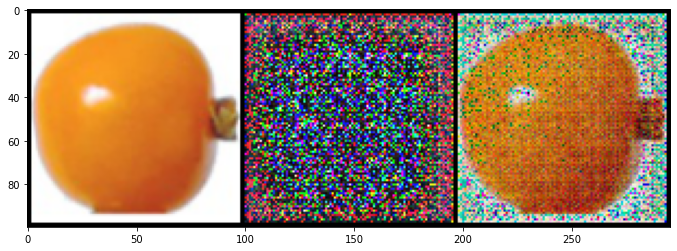

KeyboardInterrupt: ignored

In [ ]:

for idx in range(len(test_images_normal)):

    real_img = test_images_normal[idx].view(1, 3, 96, 96)
    z_o = optimize_z(real_img)
    gen_fake = generator(z_o.to(device))
    loss = Anomaly_score(Variable(real_img).to(device), gen_fake)

    diff_img = torch.abs(real_img.to(device) - gen_fake.to(device))
    # print(loss.cpu().data)
    print(f"Anomary_score = {loss.cpu().data:.3f}")
    comparison = torch.cat([real_img.to("cpu"), gen_fake.to("cpu"), diff_img.to("cpu")])
    joined_image = make_grid(comparison, nrow=3).detach().numpy()
    joined_image = np.transpose(joined_image, [1, 2, 0])
    
    plt.figure(figsize=(12, 4))
    plt.imshow((joined_image * 255).astype(np.uint8))
    plt.show()


In [ ]:
from glob import glob
import cv2

images_path = glob("./data/fruits-360/Test/Physalis/*.jpg")

def add_damage(image_path):
    
    folder = os.path.dirname(image_path)
    save_folder = folder + "_damaged"
    save_base_path = os.path.basename(image_path).replace(".jpg", "_damaged.jpg")
    save_path = os.path.join(save_folder, save_base_path)
    
    os.makedirs(save_folder, exist_ok=True)
    
    image = cv2.imread(image_path)
    center_x = random.randint(20, 76)
    center_y = random.randint(20, 76)
    color_r = random.randint(0, 255)
    color_g = random.randint(0, 255)
    color_b = random.randint(0, 255)
    
    center = (center_x, center_y)
    color = (color_r, color_g, color_b)
    
    cv2.circle(image, center = center, radius = 10, color = color,thickness=-1)
    cv2.imwrite(save_path, image)
    
[add_damage(image_path) for image_path in images_path]

test_root_anomaly = './data/fruits-360/Test/Physalis_damaged/'
test_dataset_anomaly = LoadFromFolder(test_root_anomaly, transform=transform_dict["test"])

test_images_anomaly = random.sample(list(test_dataset_anomaly), random_image_size)

Anomary_score = 14569.754


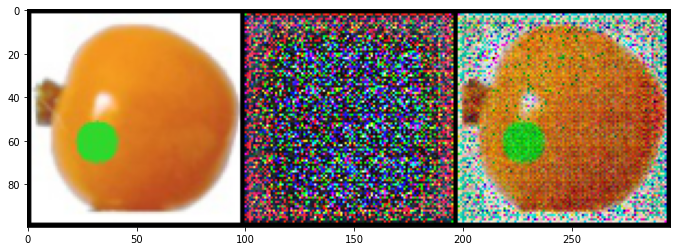

KeyboardInterrupt: ignored

In [ ]:
for idx in range(len(test_images_anomaly)):

    real_img = test_images_anomaly[idx].view(1, 3, 96, 96)
    z_o = optimize_z(real_img)
    gen_fake = generator(z_o.to(device))
    loss = Anomaly_score(Variable(real_img).to(device), gen_fake)
    
    print(f"Anomary_score = {loss.cpu().data:.3f}")
    
    diff_img = torch.abs(real_img.to(device) - gen_fake.to(device))
    comparison = torch.cat([real_img.to("cpu"), gen_fake.to("cpu"), diff_img.to("cpu")])
    joined_image = make_grid(comparison, nrow=3).detach().numpy()
    joined_image = np.transpose(joined_image, [1, 2, 0])
    
    plt.figure(figsize=(12, 4))
    plt.imshow((joined_image * 255).astype(np.uint8))
    plt.show()
